# Data Analysis on Data Analysis: 
### A Data-Driven Approach to Investigating the Role of a Data Analyst

## Introduction

As I am searching for a job within this field, I thought it would be useful to create and analyse a dataset describing the available jobs in the market. This is to further my understanding of the skills needed by the data analyst in Singapore, the progression of those skills, as well as the appreciable salary prospects.

In order to obtain this data, I designed a [webscraping algorithm](https://github.com/geraldjlsim) in python using selenium to extract relevant data from 3 local job search websites: [Indeed](https://www.indeed.com.sg), [Job Street](https://www.jobstreet.com.sg), and [Monster](https://www.monster.com.sg). The relevant webscraping scripts and scraped files can be found [here](https://github.com/geraldjlsim). The data I needed comprised of the job title, salary, minimum experience, skills keywords, as well as the company name to minimize duplicate data from skewing the data set too much.

The data was scraped on 14 April 2020, and the analysis takes the following steps:
* **Data Cleaning** - Correct errors in data collection, formatting cells, dropping unnecessary data, and transforming variables
* **Data Analysis Part 1** - Comparing the frequency of certain skill keywords between a data analyst and a data scientist, and within each experience range
* **Data Analysis Part 2** - Comparing the mean salary and minimum years of experience between experience ranges
* **Conclusions** - Summary of the results and drawing relevant takeaways from them

In [1908]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preparation

The data collected from Indeed and Job Street largely have the same formatting, and so are straightforward to merge. For Monster however, there was a specific web element containing candidate experience. Thus, I collected in a separate column as I deemed it useful, with the knowledge that I would have to fix that data before merging with the other two datasets. On top of that, there were some job cards that did not have the experience listed at all.For these, we will have to realign the salary and keyword data to the appropriate columns.

In [1909]:
# Reading the data from indeed and labelling its source for future checking
indeed_data = pd.read_csv('indeed.csv')
indeed_data['source'] = 'Indeed'
indeed_data.sample(5)

,Company,Description,Salary,Title,source
963,DBS Bank,Business Function\n\nGroup Technology and Oper...,NaN,"ED / SVP, Platform Architect, Group Consumer B...",Indeed
1399,Prime Insight,Data Engineer. Singapore. Up to Sg $96k annual...,"$96,000 a year",Data Engineer - Data Warehouse,Indeed
643,TD Securities,"Headquartered in Toronto, Canada, with more th...",NaN,"Senior Analyst, Foreign Exchange & Derivatives...",Indeed
1321,Robert Walters,An exciting Vision Software Engineer job has j...,NaN,Vision Software Engineer,Indeed
271,Bytedance,Responsibilities\n1. Manage the configuration ...,NaN,HRIS Business Analyst,Indeed


In [1910]:
# Reading the data from job street and labelling its source for future checking
jobstreet_data = pd.read_csv('jobstreet.csv')
jobstreet_data['source'] = 'Jobstreet'
jobstreet_data.sample(5)

,Company,Description,Salary,Title,source
343,JTE Recruit Pte Ltd,☑ Monday to Friday\n☑ Jurong\n☑ Basic up to $2...,SGD 1600 - SGD 2500,Laboratory Assistant / Analyst ( Basic up to $...,Jobstreet
464,VOLT,System Analyst - MES (Permanent)\nA leading cl...,SGD 4000 - SGD 6500,System Analyst - MES - level 2 & 3,Jobstreet
4953,NETS,"This role is for the entity, Banking Computer ...",Posted on 17-Mar-20,Senior Network Administrator (Infrastructure S...,Jobstreet
338,OCBC Bank (Singapore),"Description\n\nAs Adobe Analytics specialist, ...",SGD 3000 - SGD 5000,Adobe Analytics Specialist (3 months contract)...,Jobstreet
5013,MCI Career Services Pte Ltd,Benefits Summary:\nBasic salary up to $5000\nM...,Posted on 15-Mar-20,Assistant Warehouse Operations Manager (UP$500...,Jobstreet


In [1911]:
# Reading the data from monster and labelling its source for future checking
monster_data = pd.read_csv('Monster.csv')
monster_data['source'] = 'Monster'

# Create a function to format the data for uniformity with the prior two datasets
def fix_monster(row):
    if ('SGD' in row['Experience']) or ('Specified' in row['Experience']):
        row['Description'] = row['Description'] + row['Salary']
        row['Salary'] = row['Experience']
    else:
        row['Description'] = row['Experience'] + ' ' + row['Description']
    if row['Salary'] == '0-0 SGD':
        row['Salary'] = None
    elif row['Salary'] == 'Not Specified':
        row['Salary'] = None
    return row

monster_data = monster_data.apply(fix_monster, axis=1).drop('Experience',axis=1)
monster_data.sample(5)

,Company,Description,Salary,Title,source
639,DC Frontiers Pte Ltd,5-15 Years We are looking for an individual wi...,None,"Software Engineer, Machine Learning",Monster
1082,Company Name Confidential,2-5 Years Hiring for Service Desk Skills : Ser...,None,Service Desk,Monster
2885,DBS Bank Ltd,Posted: 22 days ago APPLYJob Description : Wha...,None,"SVP / VP, Design Lead, Product Designer, Consu...",Monster
3164,Accenture Pte Ltd,8-11 Years Job Description Accenture isa leadi...,None,DevOps Architect,Monster
1922,Oracle Corporation Asia Pacific Division,3-6 Years Job Description : Preferred Qualific...,None,Security Operation Center (SOC) Analyst,Monster


In [1912]:
# Combine all the job listings into one dataset, dropping any duplicates
jobs_data = pd.concat([indeed_data,jobstreet_data,monster_data], axis = 0).drop_duplicates()
initial_size = len(jobs_data)
jobs_data.sample(5)

,Company,Description,Salary,Title,source
2737,DBS Bank Ltd,5-8 Years Job Description : BusinessFunction G...,None,"VP / AVP, Technology Risk Manager, Operational...",Monster
1080,Global Search Partners Pte Ltd,The Benefits Analyst will be the key analyst f...,Posted on 23-Mar-20,Benefits Analyst,Jobstreet
3881,The Supreme HR Advisory Pte. Ltd.,● Islandwide – Singapore\n● Attractive Salary ...,SGD 4000 - SGD 5000,Senior Chemist [5 days / West / XRF Equipment ...,Jobstreet
4110,Peoplebank Singapore Pte Ltd,"1 Year Contract\nSalary - up to $9,500 monthly...",SGD 8000 - SGD 9500,SMB Marketing Operations Manager,Jobstreet
650,Cloud Kinetics Solutions Pte Ltd,4-7 Years Tableau Developer Skills : Infrastru...,None,Development Test engineer,Monster


## Data Cleaning

In order to get insight of the data, we will first have to clean it for visualization:
* **Keyword Extraction**: Check for the existence of certain Keywords from the job description
* **Job Title**: Use the keywords to distinguish between data analysts and data scientists
* **Job Experience** Use the keywords to create well-defined job experience tiers and remove any additional job roles that do not pertain to the analysis
* **Salary** Convert salary data to a list of numbers and extract the salary minimum offer, salary highest offer and calculate the midpoint of each job offer
* **Observations** Make some observations on the cleaned data

#### Keyword Extraction

We choose keywords that will help us to:
* Differentiate between the job experience tiers, junior, senior
* Differentiate between data analysts and data scientists
* Identify skills that will be required for each role

In [1913]:
# Define the list of useful keywords
keywords = ['intern','senior','scientist','analyst','python',r'\br\b','sql','tableau','power','qlik','aws','azure','deep','neural','clustering',' random forest','regression','decision tree','machine learning','java','matlab']

In [1914]:
# Create truth tables for the existence of keywords in the job description
for keyword in keywords:
    jobs_data[keyword] = jobs_data['Description'].str.lower().str.contains(keyword)
# Rename the R column to remove the regular expression conditions
jobs_data = jobs_data.rename({'\\br\\b':'r'},axis =1)

#### Job Title
If the role is for a Data Analyst, either:
* The words 'data' is paired with 'analyst' or 'analytics' in the job title
* Either the word 'analyst' or 'analytics' are in the job title AND one of the relevant programming languages is mentioned in the job description

If the role is for a Data Scientist, either:
* The words 'data' is paired with 'scientist' or 'science' in the job title
* Either the word 'scientist' is in the job title AND one of the relevant programming languages is mentioned in the job description

We will classify each job listing, deleting the remaining that do not meet the classifications.

In [1915]:
# Create a series that returns true for any rows that meet the data analyst criteria and false otherwise
da_mask = (((jobs_data['Title'].str.lower().str.contains('analyst')) | (jobs_data['Title'].str.lower().str.contains(
    'analytics'))) & (jobs_data['python'] | jobs_data['r'] | jobs_data['sql'] | jobs_data['java'] | jobs_data['matlab'])) | (
    jobs_data['Title'].str.lower().str.contains('data') & (jobs_data['Title'].str.lower().str.contains('analyst') | (
    jobs_data['Title'].str.lower().str.contains('analytics'))))

# Create a series that returns true for any rows that meet the data scientist criteria and false otherwise
ds_mask = (((jobs_data['Title'].str.lower().str.contains('scientist')) | (jobs_data['Title'].str.lower().str.contains(
    'science'))) & (jobs_data['python'] | jobs_data['r'] | jobs_data['sql'] | jobs_data['java'] | jobs_data['matlab'])) | (
    jobs_data['Title'].str.lower().str.contains('data') & jobs_data['Title'].str.lower().str.contains('scientist'))

# Define the relevant job titles and delete the remaining unclassified job titles
jobs_data.loc[da_mask,'title_cleaned'] = 'Data Analyst'
jobs_data.loc[ds_mask,'title_cleaned'] = 'Data Scientist'
jobs_data = jobs_data[da_mask | ds_mask]

#### Job Experience - Part 1

Before we use the keywords, we can also use another metric to determine the job experience of a candidate. That is the minimum number of years that they have worked in the field. We will first extract the minimum amount of years that the candidates are required to have worked before classifying them.

In [1916]:
# Extract strings where a full word and 8 characters precede 'year' using a row-wise function
def thing(row):
    # There may be a more elegant/efficient way to do this
    # This extracts the strings from each description and returns a list of the strings 
    row = "-/-".join(row.str.extractall(r'([^\s]+........year)').stack()).split('-/-')
    return row
jobs_data['min_yrs'] = jobs_data[['Description']].apply(thing,axis=1)

In [1917]:
# Define a function that takes the list of strings '*********year' and returns the minimum number of years
# Example "minimum of 8 years" -> returns 8
def years_cleaner(string_list):
    # Convert empty lists to null values
    if not string_list:
        return None
    
    for string in string_list:
        # For each string, convert for easy parsing
        string = string.lower()
        string = string.replace(' ','')
        string = string.replace('+','')
        string = string.replace('to','-')
        string = string.replace('one','1')
        string = string.replace('two','2')
        string = string.replace('three','3')
        string = string.replace('four','4')
        string = string.replace('five','5')
        string = string.replace('six','6')
        string = string.replace('seven','7')
        string = string.replace('eight','8')
        string = string.replace('nine','9')
        # Define keywords that highlight a minimum requirement
        keywords = ['min','least','than','-','with',':','experience','possess','>','and3','and12', 'internship/1','scientist('
                      'require','approx','has','have','analys','about',')','overall','of3','over5','industryand']
        # Define keywords that hightlight a minimum requirement with some leeway
        jr_keywords = ['ideal','prefer','junior']
        # Define a capture group for the required number
        p = re.compile(r'([0-9]?[0-9])-?[0-9]?[0-9]?[two]?[four]?\)?year')
        # If the string contains any of the keywords, return the number of minimum years
        if any(ele in string for ele in keywords):       
            try:
                string = int(p.findall(string)[0])
                if string == 'four':
                    string = 4
                elif string == 'two':
                    string = 2
            except:
                # Exceptions where keywords exist but no numbers exist
                string = None
        # If the string contains the keywords that give some leeway, return the number of minimum years minus 1 year
        elif any(ele in string for ele in jr_keywords):
            string = int(p.findall(string)[0])
            if string < 1:
                string = 0
            else:
                string = string-1
        else:
            string = None
        return string

In [1918]:
# Apply the function to get the minimum years required for each role
jobs_data['min_yrs'] = jobs_data['min_yrs'].apply(years_cleaner)

In [1919]:
# The frequency of each minimum year requirement
jobs_data['min_yrs'].value_counts().sort_index()

0.0       2
1.0      49
2.0     101
3.0      91
4.0      32
5.0      68
6.0       8
7.0       5
8.0      15
9.0       4
10.0     17
12.0      2
13.0      1
15.0      5
20.0      2
Name: min_yrs, dtype: int64

#### Job Experience - Part 2

We classify the job experience based on:
* Interns: Job is specifically for interns
* Juniors: Job is specifically for juniors and anyone with less than 3 years of experience
* Mid-level: Job is specifically for mid-level and anyone with 3-5 years of experience
* Senior: Job is specifically for seniors and anyone with >5 years of experience

Where in any case, the minimum number of years worked takes presidence over the sepecific mention of the role in the job title.

In [1920]:
# Classify jobs into job experience tiers
def expertise(row):
    if 'intern' in row['Title'].lower():
        return 'intern'
    if 'junior' in row['Title'].lower():
        return 'junior'
    if (row['senior']) or ('senior' in row['Title'].lower()):
        return 'senior'
    if ('lead' in row['Title'].lower() or 'head' in row['Title'].lower()):
        return 'senior'
    if row['min_yrs'] < 3:
        return 'junior'
    if row['min_yrs'] < 6 and row['min_yrs']  > 2:
        return 'mid-level'
    if row['min_yrs']  > 4:
        return 'senior'

jobs_data['experience'] = jobs_data.apply(expertise,axis = 1).fillna('unknown')

#### Salary

In order to obtain the midpoint salary of each job offer, we need to take the following steps:
* Extract the numerical low and the numerical high of the salaries
* Standardise the unit of salary to be $/mth
* Get the average of the high and low salary offers

In [1921]:
# Convert strings without salary numbers into null values
jobs_data.loc[(jobs_data['Salary'].str.contains('Posted')) & jobs_data['Salary'].notnull(),'Salary'] = None
# Create a new column converting the salary string into the format 'valuea - valueb'
jobs_data['salary_cleaned'] = jobs_data['Salary'].str.replace(' ','')
jobs_data['salary_cleaned'] = jobs_data['salary_cleaned'].str.replace('SGD','')
jobs_data['salary_cleaned'] = jobs_data['salary_cleaned'].str.replace('$','')
jobs_data['salary_cleaned'] = jobs_data['salary_cleaned'].str.replace(',','')
jobs_data['salary_cleaned'] = jobs_data['salary_cleaned'].str.replace('amonth','')
jobs_data['salary_cleaned'] = jobs_data['salary_cleaned'].str.replace('ayear','')
jobs_data['salary_cleaned'] = jobs_data['salary_cleaned'].str.replace('anhour','')
# split valuea and valueb into a list
jobs_data['salary_cleaned'] = jobs_data['salary_cleaned'].str.split('-')

In [1922]:
# Extract the high and low values of the salary from the list
def salary_low(row):
    try:
        return row['salary_cleaned'][0]
    except:
        return row['salary_cleaned']

def salary_high(row):
    try:
        return row['salary_cleaned'][1]
    except:
        try:
            return row['salary_cleaned'][0]
        except:
            return row['salary_cleaned']
        
jobs_data['salary_low'] = jobs_data.apply(salary_low, axis = 1)
jobs_data['salary_high'] = jobs_data.apply(salary_high, axis = 1)

In [1923]:
# Some strings contain yearly and hourly salaries, express them in terms of monthly salaries
yearly_mask = (jobs_data['Salary'].notnull()) & (jobs_data['Salary'].str.contains('year'))
hourly_mask = (jobs_data['Salary'].notnull()) & (jobs_data['Salary'].str.contains('hour'))

jobs_data.loc[yearly_mask, 'salary_low'] = jobs_data.loc[yearly_mask, 'salary_low'].apply(float)/12
jobs_data.loc[yearly_mask, 'salary_high'] = jobs_data.loc[yearly_mask, 'salary_high'].apply(float)/12
jobs_data.loc[hourly_mask, 'salary_low'] = jobs_data.loc[hourly_mask, 'salary_low'].apply(float)*8*5*4
jobs_data.loc[hourly_mask, 'salary_high'] = jobs_data.loc[hourly_mask, 'salary_high'].apply(float)*8*5*4

# Some strings contain yearly salaries but do not contain the word year exactly
# Choose values that are higher than the upper bound of salaries and convert them

def yearly2monthlylow(row):
    try: 
        row['salary_low'] = float(row['salary_low'])
        if row['salary_low'] > 20000:
            row['salary_low'] = row['salary_low']/12
        return row
    except TypeError:
        return row

def yearly2monthlyhigh(row):
    try: 
        row['salary_low'] = float(row['salary_low'])
        if row['salary_low'] > 20000:
            row['salary_high'] = float(row['salary_high'])/12
        return row
    except TypeError:
        return row

jobs_data = jobs_data.apply(yearly2monthlylow,axis=1)
jobs_data = jobs_data.apply(yearly2monthlyhigh,axis=1)

In [1924]:
# Final converting of all the values and deriving salary mid-point
jobs_data['salary_high'] = jobs_data['salary_high'].astype(float)
jobs_data['salary_low'] = jobs_data['salary_low'].astype(float)
jobs_data['mean_salary'] = (jobs_data['salary_high']+jobs_data['salary_low'])/2
jobs_data['mean_salary'] = jobs_data['mean_salary'].apply(lambda x: np.nan if (x==0) else x)

#### Observations

In [1925]:
print('Initial Dataset: {}'.format(initial_size))
print('\nCleaned Dataset: {}'.format(len(jobs_data)))

Initial Dataset: 10190

Cleaned Dataset: 1412


After cleaning the data we are left with 1412 samples of data, as compared to the 10190 we started with. This was expected, as the search engines allowed for a very broad range of results. At this point I am confident that most of the data that remains is useful to our study.

In [1926]:
# Calculate and print the initial, usable, and percentage of usable data for each website
indeed_init = len(indeed_data)
indeed_final = jobs_data.groupby('source').count()['Company'].loc['Indeed']
indeed_percent = round(indeed_final/indeed_init*100)

jobstreet_init = len(jobstreet_data)
jobstreet_final = jobs_data.groupby('source').count()['Company'].loc['Jobstreet']
jobstreet_percent = round(jobstreet_final/jobstreet_init*100)

monster_init = len(monster_data)
monster_final = jobs_data.groupby('source').count()['Company'].loc['Monster']
monster_percent = round(monster_final/monster_init*100)

print('Percentage of usable Indeed samples:\n{0} / {1} = {2} %'.format(indeed_final, indeed_init,indeed_percent))
print('Percentage of usable Job Street samples:\n{0} / {1} = {2} %'.format(jobstreet_final, jobstreet_init,jobstreet_percent))
print('Percentage of usable Monster samples:\n{0} / {1} = {2} %'.format(monster_final, monster_init,monster_percent))

Percentage of usable Indeed samples:
643 / 1628 = 39.0 %
Percentage of usable Job Street samples:
475 / 5351 = 9.0 %
Percentage of usable Monster samples:
294 / 3211 = 9.0 %


In terms of search efficiency, indeed Indeed seems to produce the most number of useful results. While both Job Street and Monster returned more than double the search results of Indeed, Indeed still returned more than 4 times of useable results than the rest.

In [1927]:
jobs_final['title_cleaned'].value_counts()

Data Analyst      1012
Data Scientist     400
Name: title_cleaned, dtype: int64

Of the useable data, Data Scientists comprise of only less than a third of the sample. We may do well to avoid drawing hefty conclusions from the Data Scientist portion of the data set, seeing as the set of the data containing both salary and minimum year requirements is also lacking, and will reduce the sample size even more for those metrics.

In [1928]:
jobs_data = jobs_data.drop('source', axis =1)

## Data Analysis - Part 1

To find out the skills required to be a Data Analyst or Data Scientist, we will plot a bar chart charting the frequency of each keyword corresponding to each role.

In [1929]:
# The columns currently in the data frame
jobs_data.columns

Index(['Company', 'Description', 'Salary', 'Title', 'intern', 'senior',
       'scientist', 'analyst', 'python', 'r', 'sql', 'tableau', 'power',
       'qlik', 'aws', 'azure', 'deep', 'neural', 'clustering',
       ' random forest', 'regression', 'decision tree', 'machine learning',
       'java', 'matlab', 'title_cleaned', 'min_yrs', 'experience',
       'salary_cleaned', 'salary_low', 'salary_high', 'mean_salary'],
      dtype='object')

In [1930]:
# Create a new data frame with the cleaned data and keyword columns necessary for this analysis
index = [25,27,26,28,31,29,30,0]
for i in range(8,24):
    index.append(i)
jobs_final = jobs_data.iloc[:,index]
jobs_final.sample(5)

,title_cleaned,experience,min_yrs,salary_cleaned,mean_salary,salary_low,salary_high,Company,python,r,...,aws,azure,deep,neural,clustering,random forest,regression,decision tree,machine learning,java
1900,Data Analyst,senior,NaN,"[3500, 5000]",4250.0,3500.0,5000.0,Cargo Community Network Pte Ltd,False,False,...,False,False,False,False,False,False,False,False,False,True
845,Data Analyst,unknown,NaN,None,NaN,NaN,NaN,Sciente Consulting Pte. Ltd,False,False,...,False,False,False,False,False,False,False,False,False,False
337,Data Analyst,unknown,NaN,None,NaN,NaN,NaN,Maventree Technology Pte Ltd,False,False,...,False,False,False,False,False,False,False,False,False,True
772,Data Scientist,senior,NaN,None,NaN,NaN,NaN,DBS Bank Ltd,False,False,...,False,False,False,False,False,False,False,False,False,False
727,Data Scientist,mid-level,3.0,"[5500, 9500]",7500.0,5500.0,9500.0,JobStudio Pte Ltd,True,True,...,False,False,False,False,False,False,False,False,False,False


In [1931]:
# Create a pivot table alloting the frequency distribution of keywords with the corresponding role
aggcolumns1 = jobs_final.columns[7:25]
keywords_data = pd.pivot_table(jobs_final,values = aggcolumns1, columns = 'title_cleaned',aggfunc='sum')

In [1932]:
# Normalize the frequency distributions so as to be able to present them in percentages
total_da = (jobs_final[jobs_final['title_cleaned']=='Data Analyst'].iloc[:,7:25].sum(axis=1)!=0).sum()
total_ds = (jobs_final[jobs_final['title_cleaned']=='Data Scientist'].iloc[:,7:25].sum(axis=1)!=0).sum()
keywords_data['Data Analyst'] = keywords_data['Data Analyst']/total_da*100
keywords_data['Data Scientist'] = keywords_data['Data Scientist']/total_ds*100

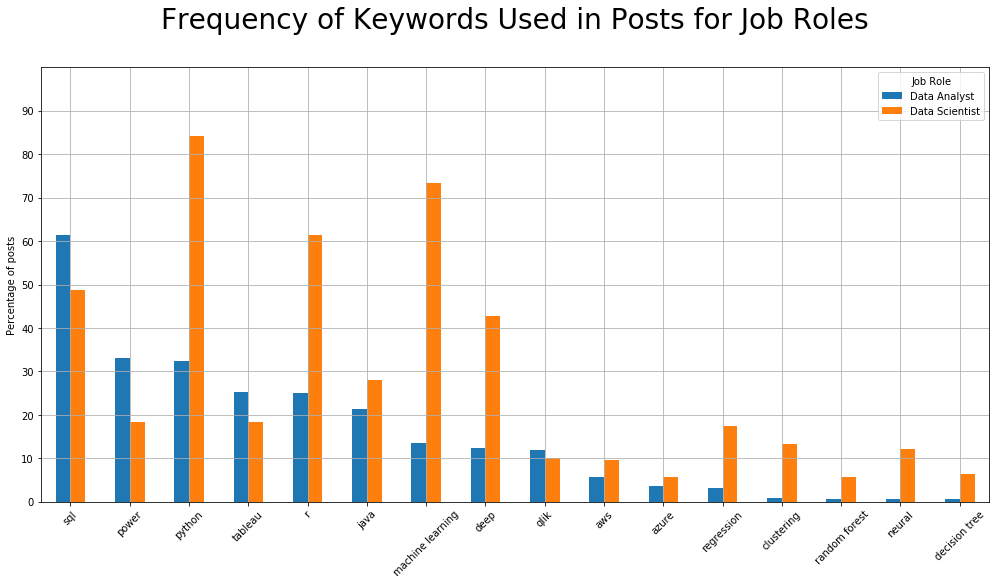

In [1933]:
#Plot the distribution as percentages
fig, ax =plt.subplots(figsize = (17,8))
keywords_data.sort_values('Data Analyst', ascending = False).plot.bar(ax = ax)

#Plot Settings
ax.set_ylim([0,100])
ax.set_title('Frequency of Keywords Used in Posts for Job Roles\n', {'fontsize': 28})
ax.legend(title='Job Role')
ax.grid(True)
ax.set_yticks(range(0,100,10), minor=False)
ax.set_ylabel('Percentage of posts')
xticklabels = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

From this chart we can see that there is quite a bit of crossover within the two roles, especially in the proportions of each skill required for each role. However, the two start to deviate in that: 

* Data Scientists required to have substantially more **Programming** skills than Data Analysts
* Conversely, Data Analysts are required to have skills with **Data Visualization** software more than Data Scientists
* Finally, Data Analysts are hardly required to have any **Machine Learning** skills whereas the bulk of Data Scientists need to be able to utilize machine learning and further, **Neural Networks**


In [1934]:
# Create a new data frame containing only data analyst job posts for junior, mid-level or senior positions
da_data = jobs_final[(jobs_final['title_cleaned']=='Data Analyst') & (jobs_final['experience'] != 'unknown')& (jobs_final['experience'] != 'intern')]

# Create a pivot table alloting the frequency distribution of keywords with the corresponding experience level
da_data = pd.pivot_table(da_data,values = aggcolumns1, columns = 'experience',aggfunc='sum')

# Normalize the frequency distributions so as to be able to present them in percentages
total_da_jr = (jobs_final[(jobs_final['title_cleaned']=='Data Analyst')&(jobs_final['experience']=='junior')].iloc[:,7:25].sum(axis=1)!=0).sum()
total_ds_ml = (jobs_final[(jobs_final['title_cleaned']=='Data Analyst')&(jobs_final['experience']=='mid-level')].iloc[:,7:25].sum(axis=1)!=0).sum()
total_ds_sn = (jobs_final[(jobs_final['title_cleaned']=='Data Analyst')&(jobs_final['experience']=='senior')].iloc[:,7:25].sum(axis=1)!=0).sum()
da_data['junior'] = da_data['junior']/total_da_jr*100
da_data['mid-level'] = da_data['mid-level']/total_ds_ml*100
da_data['senior'] = da_data['senior']/total_ds_sn*100

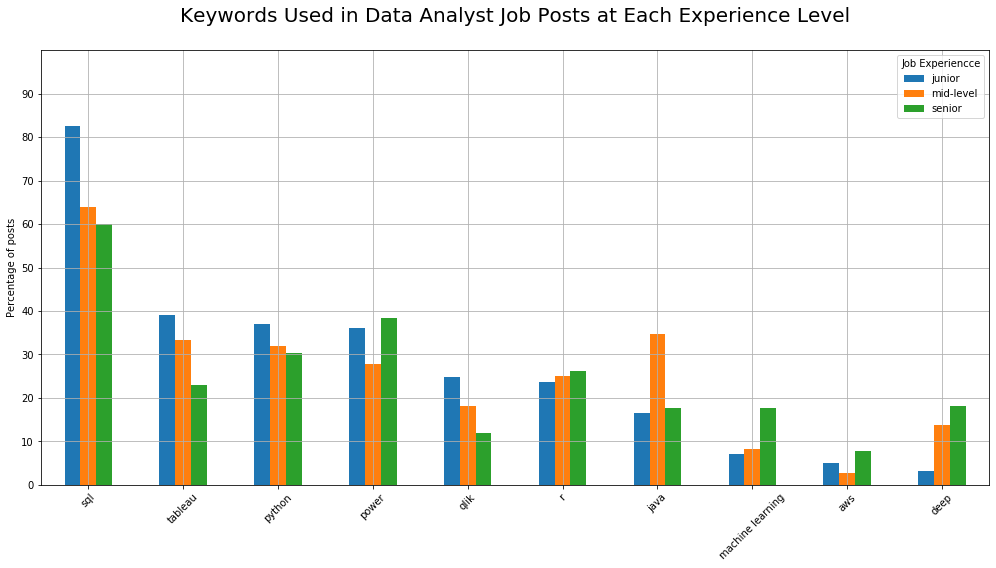

In [1935]:
#Plot the distribution as percentages
fig, ax =plt.subplots(figsize = (17,8))
da_data.sort_values('junior',ascending = False).iloc[0:10].plot.bar(ax = ax)

#Plot Settings
ax.set_ylim([0,100])
ax.set_title('Keywords Used in Data Analyst Job Posts at Each Experience Level\n', {'fontsize': 20})
ax.legend(title='Job Experiencce')
ax.grid(True)
ax.set_ylabel('Percentage of posts')
ax.set_yticks(range(0,100,10), minor=False)
xticklabels = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

Diving further into our analysis, we want to look specifically at the skills required at each experience level for a Data Analyst. As we are mainly interested about the Data Analyst role in this study, we will not do the same for the Data Scientist role.

On first glance we can ascertain that: 
* **SQL** is very in demand, especially for junior Data Analysts
* **Python** is the most sought after **Programming Language**, followed by **R**
* **Tableau** is the most sought after **Data Visualization** software
* As the job experience level gets higher, **Machine Learning**'s importance also increases, but not to a high level
* Further, as job experience level gets higher, **Data Visualization** is less important, and **Machine Learning** is more important. Presumably, senior Data Analysts do more abstract analysis than juniors


## Data Analysis - Part 2

In this section, we will first be comparing the salary entrypoints for each experience level of a Data Analyst with a Data Scientist, as well as the minimum years of experience for each role. Following that, we will hone in on the average salary offer for the number of years of experience.

In [1936]:
# Create separate data frames for both data analyst and data scientist positions 
da_data = jobs_final[(jobs_final['title_cleaned']=='Data Analyst')].iloc[:,0:7]
ds_data = jobs_final[(jobs_final['title_cleaned']=='Data Scientist') & (jobs_final['experience'] != 'intern')].iloc[:,0:7]
# Define order for plotting
plot_order = ['junior','mid-level','senior']

In [1937]:
# Reduce outlier data
da_data= da_data[~(da_data['salary_low']>13000)]
da_data= da_data[~((da_data['mean_salary']>8000) & (da_data['experience']=='junior'))]
da_data= da_data[~((da_data['mean_salary']>10000) & (da_data['experience']=='mid-level'))]
ds_data= ds_data[~((ds_data['mean_salary']>9000) & (ds_data['experience']=='junior'))]

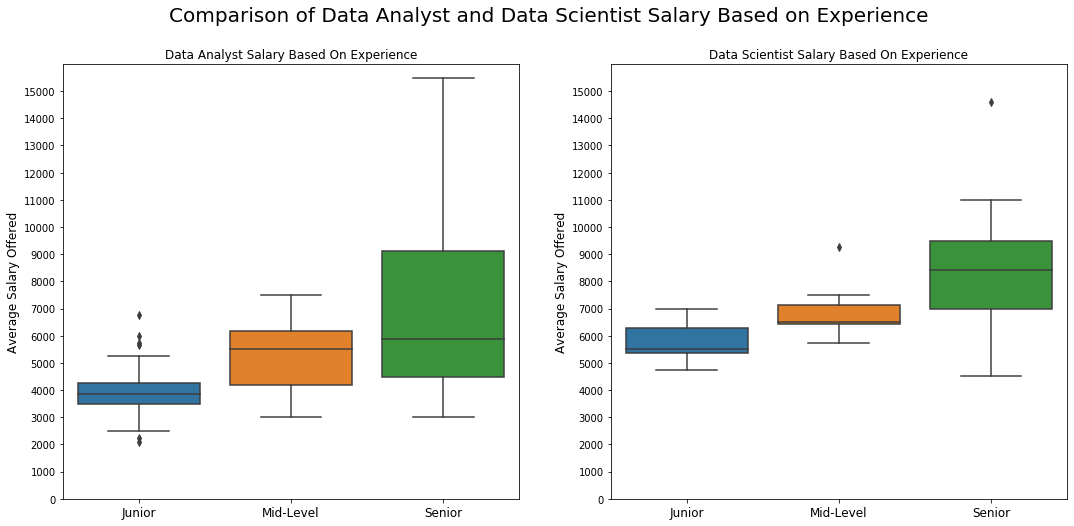

In [1949]:
# Plot box plots of salary based on experience
fig, ax =plt.subplots(1,2,figsize = (18,8))
ax[0].set_ylim([0,16000])
ax[1].set_ylim([0,16000])
ax[0].set_yticks(np.arange(0, 16000, 1000))
ax[1].set_yticks(np.arange(0, 16000, 1000))
ax[0].set_title('Data Analyst Salary Based On Experience')
sns.boxplot(x = 'experience', y = 'mean_salary', data = da_data, order = plot_order ,ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_xticklabels(['Junior','Mid-Level','Senior'], fontsize = 12)
ax[0].set_ylabel('Average Salary Offered', fontsize = 12)
ax[1].set_title('Data Scientist Salary Based On Experience')
sns.boxplot(x = 'experience', y = 'mean_salary', data = ds_data, order = plot_order, ax=ax[1])
ax[1].set_xticklabels(['Junior','Mid-Level','Senior'], fontsize = 12)
ax[1].set_ylabel('Average Salary Offered', fontsize = 12)
fig.suptitle('Comparison of Data Analyst and Data Scientist Salary Based on Experience', fontsize=20)
label_axis = ax[1].set_xlabel('')

As expected, the salary for each level of seniority increases accordingly, with the junior Data Scientist salary significantly (roughly $1000) higher than the Data Analyst salary. It can be reasoned that as Data Scientists usually enter the job market being expected to have done a PHd as opposed to the BSc of a Data Analyst, this pay discrepency is somewhat reasonable. Not to mention the requirement of higher level skills by the Data Scientist.

Interestingly, the upper limit of the Senior Data Analyst and the Senior Data Scientist salary seems to line up, and this is also fairly in line with the expectation that Senior Data Analysts use more Artificial Intelligence skills in their analysis.

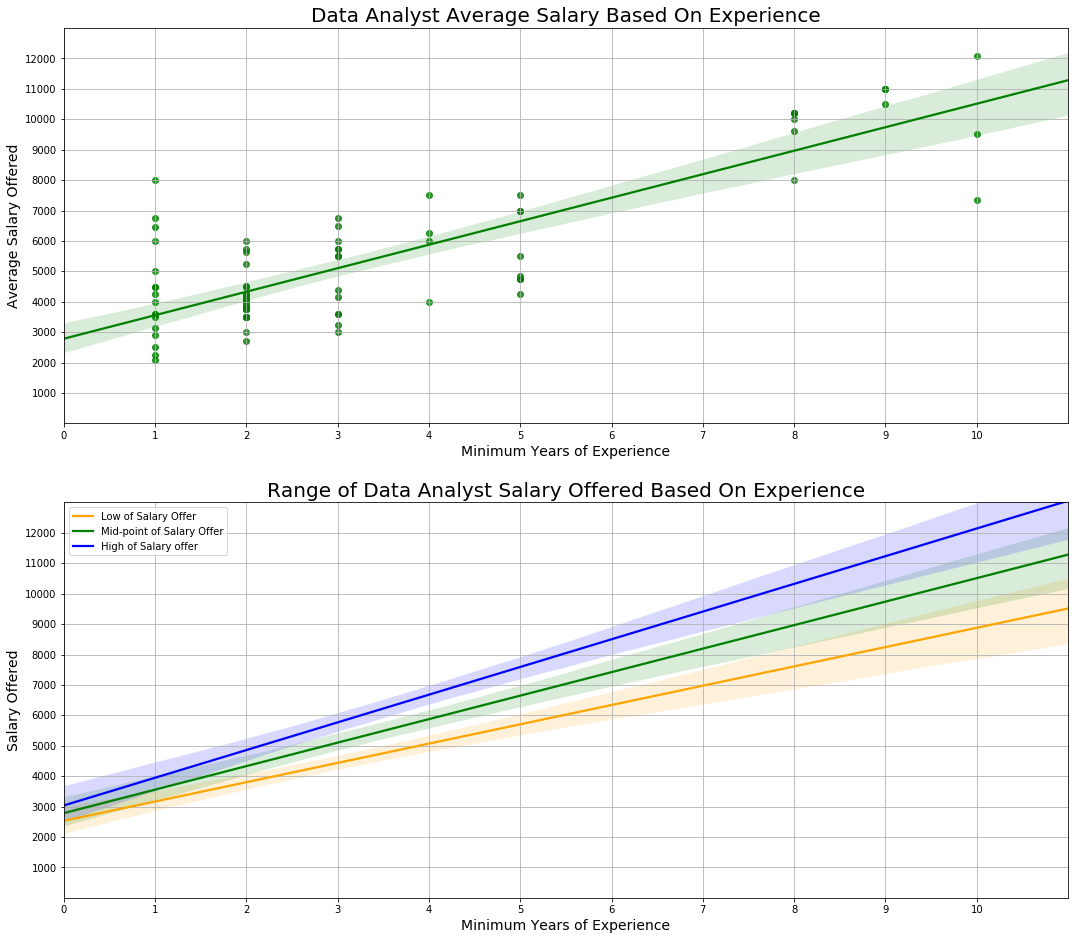

In [1948]:
fig, ax =plt.subplots(2,1, figsize = (18,16))

ax[0].set_xticks(range(0,11,1))
ax[0].set_yticks(range(1000,13000,1000))
ax[0].grid(True)
ax[1].set_xticks(range(0,11,1))
ax[1].set_yticks(range(1000,13000,1000))
ax[1].grid(True)
ax[0].set_xlim(0,11)
ax[0].set_ylim(0,13000)

sns.regplot(da_data['min_yrs'],da_data['mean_salary'], ax = ax[0], color = "g")
ax[0].set_xlabel('Minimum Years of Experience', fontsize = 14)
ax[0].set_ylabel('Average Salary Offered', fontsize = 14)
ax[0].set_title('Data Analyst Average Salary Based On Experience', fontsize = 20)

ax[1].set_xlim(0,11)
ax[1].set_ylim(0,13000)

sns.regplot(da_data['min_yrs'],da_data['salary_low'], ax = ax[1], color = "orange", scatter = False)
sns.regplot(da_data['min_yrs'],da_data['mean_salary'], ax = ax[1], color = 'g', scatter = False)
sns.regplot(da_data['min_yrs'],da_data['salary_high'], ax = ax[1], color = "b", scatter = False)
ax[1].set_xlabel('Minimum Years of Experience', fontsize = 14)
ax[1].set_ylabel('Salary Offered', fontsize = 14)
ax[1].set_title('Range of Data Analyst Salary Offered Based On Experience', fontsize = 20)
ax[1].legend(['Low of Salary Offer','Mid-point of Salary Offer','High of Salary offer'])

Despite a few outliers, the clustering of the data shows a clear correlation between the minimum years of experience and salary offered by the recruiter. It is important to note however, that the sample is more localized towards the lower end of experience, probably since data analysts with senior levels of experience would tend to be head hunted or be given a different senior level role. Given more samples at the higher end of the spectrum, it is likely that the expected average salary would curve along the years of experience as opposed to having a linear relationship.

The average starting salary to be expected is roughly \\$3000, and the average pay difference per year of experience is about $750. However, with the small sample size despite having scraped about 10000 data points, it remains to be seen if this model is an accurate predictor for the average salary of a Data Analyst. 

## Conclusion

Through this study we have come to a few conclusions regarding the exact role of a Data Analyst.

First of all, we have seen that in terms of skill, the most valued software skill of a Data Analyst is to be able to make SQL queries followed by knowledge in some form of data visualization software, either Tableau or Power BI. The initial ability for a data analysis to draw insight from the data is less important than their ability to visualize the data.

Compared to the Data Scientist, a Data Analyst would use lower abstraction in their work to come to conclusions about data, whereas a Data Scientist would be able to use higher level statistical toolkits to do predictive analysis. This distinction gets less clear the more senior the candidate, as Data Analysts start to require the use of Machine Learning and Neural Networks later on.

Furthermore, the Data Analyst can expect their salary to start around \\$3000 and increase regularly over time.

Contextually, for a fresh graduate based in Singapore who is looking to get into Data Analytics(like myself), it is essential to first ensure some proficiency in SQL as well as the ability to use a Data Visualization software; Tableau would be my choice. A programming language is sought after, but it might be possible to get a job without one. In any case, learning Python would be a good start for any Data Analyst. 

With these skills in check, I would look to Indeed for the most relevant job search results for a junior position with a starting pay of roughly $3000.

Later on, it would be essential to keep learning and incorporating more techniques in your data journey, slowly working towards machine learning. Picking up a Masters or PhD in Data Science along the way would be nice, and provide a decent pay bump as well as an option to branch into Data Science as well as the broader field of Artificial Intelligence.

In [1950]:
# extra code

# ds_data.plot.scatter(x = 'min_yrs', y='mean_salary')

# fig, ax =plt.subplots(1,2,figsize = (18,8))
# ax[0].set_ylim([0,14000])
# ax[1].set_ylim([0,14000])
# ax[0].set_yticks(np.arange(0, 14000, 1000))
# ax[1].set_yticks(np.arange(0, 14000, 1000))
# sns.boxplot(x = 'experience', y = 'salary_low', data = da_data, order = plot_order ,ax=ax[0])
# sns.boxplot(x = 'experience', y = 'salary_low', data = ds_data, order = plot_order, ax=ax[1])

# fig, ax =plt.subplots(1,2,figsize = (18,8))
# ax[0].set_ylim([0,18000])
# ax[1].set_ylim([0,18000])
# ax[0].set_yticks(np.arange(0, 18000, 1000))
# ax[1].set_yticks(np.arange(0, 18000, 1000))
# sns.boxplot(x = 'experience', y = 'salary_high', data = da_data, order = plot_order ,ax=ax[0])
# sns.boxplot(x = 'experience', y = 'salary_high', data = ds_data, order = plot_order, ax=ax[1])

# pd.pivot_table(da_data, values = ['mean_salary'], columns = 'min_yrs',aggfunc='mean')

# pd.pivot_table(ds_data, values = ['mean_salary'], columns = 'min_yrs',aggfunc='mean')

# Plot box plots of minimum years required for role
# fig, ax =plt.subplots(1,2,figsize = (18,8))
# ax[0].set_ylim([0,15])
# ax[1].set_ylim([0,15])
# ax[0].set_yticks(np.arange(0, 15, 1))
# ax[1].set_yticks(np.arange(0, 15, 1))
# ax[0].set_title('Data Analyst Experience for Role')
# sns.boxplot(x = 'experience', y = 'min_yrs', data = da_data, order = plot_order ,ax=ax[0])
# ax[0].set_xlabel('')
# ax[0].set_xticklabels(['Junior','Mid-Level','Senior'], fontsize = 12)
# ax[0].set_ylabel('Minimum Experience (Years)', fontsize = 12)
# ax[1].set_title('Data Scientist Experience for Role')
# sns.boxplot(x = 'experience', y = 'min_yrs', data = ds_data, order = plot_order, ax=ax[1])
# ax[1].set_xticklabels(['Junior','Mid-Level','Senior'], fontsize = 12)
# ax[1].set_ylabel('Minimum Experience (Years)', fontsize = 12)
# label_axis = ax[1].set_xlabel('')